In [1]:
from dtuprosys.chemometrics.datasets import load_train_data
import matplotlib.pyplot as plt

from chemotools.derivative import SavitzkyGolay
from chemotools.scattering import MultiplicativeScatterCorrection, StandardNormalVariate
from chemotools.smoothing import SavitzkyGolayFilter

In [2]:
spectra, hplc = load_train_data()
spectra = spectra.loc[:, 950:1400]


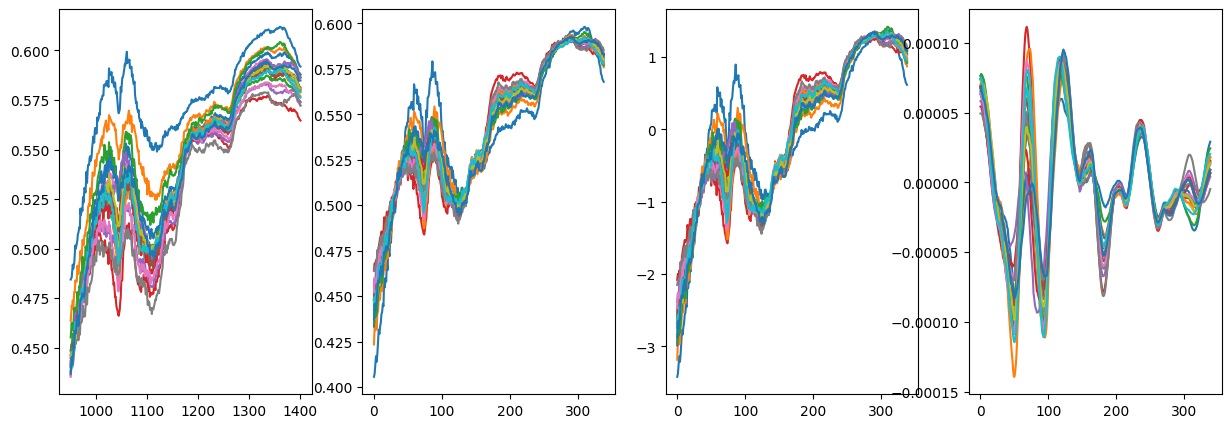

In [3]:
msc = MultiplicativeScatterCorrection(use_mean=True, use_median=False)
snv = StandardNormalVariate()
sg = SavitzkyGolay(window_size=51, polynomial_order=2, derivate_order=2, mode="nearest")

spectra_msc = msc.fit_transform(spectra)
spectra_snv = snv.fit_transform(spectra)
spectra_sg = sg.fit_transform(spectra)

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(spectra.T)
ax[1].plot(spectra_msc.T)
ax[2].plot(spectra_snv.T)
ax[3].plot(spectra_sg.T)
plt.show()


In [4]:
import numpy as np

def whittaker_smooth(x,lam):
    """Smooth data by minimizing the Whittaker functional.
    Parameters
    ----------
    x : array_like
        The data to be smoothed.
    Returns
    -------
    x_smooth : ndarray
        The smoothed data.
    Notes
    -----
    The Whittaker functional is a penalized least-squares functional that
    finds a smooth curve that fits the data. The smoothing parameter
    `lam` is determined by minimizing the generalized cross-validation
    functional.
    """
    x = np.asarray(x)
    n = len(x)
    D = np.diff(np.eye(n), 1)
    w = np.ones(n)
    for i in range(2):
        W = np.diag(w)
        Z = W + lam * np.dot(D, D.T)
        z = np.linalg.solve(Z, w * x)
        w = np.sqrt(np.maximum(z, 0))
    return z


In [5]:
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth1(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

In [8]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import StandardScaler

from chemotools.utils.check_inputs import check_input


class WhittakerSmooth(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lam: float = 1e2,
        differences: int = 2,
    ):
        self.lam = lam
        self.differences = differences

    def fit(self, X: np.ndarray, y=None) -> "WhittakerSmooth":
        # Check that X is a 2D array and has only finite values
        X = check_input(X)

        # Set the number of features
        self.n_features_in_ = X.shape[1]

        # Set the fitted attribute to True
        self._is_fitted = True

        return self

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        # Check that the estimator is fitted
        check_is_fitted(self, "_is_fitted")

        # Check that X is a 2D array and has only finite values
        X = check_input(X)
        X_ = X.copy()

        # Check that the number of features is the same as the fitted data
        if X_.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features but got {X_.shape[1]}")

        # Calculate the whittaker smooth
        for i, x in enumerate(X_):
            X_[i] = self._calculate_whittaker_smooth(x)
            
        return X_.reshape(-1, 1) if X_.ndim == 1 else X_

    def _calculate_whittaker_smooth(self, x):
        x = np.asarray(x)
        n = len(x)
        D = np.diff(np.eye(n), self.differences)
        w = np.ones(n)
        for i in range(3):
            W = np.diag(w) + 1e-8*np.eye(n)
            Z = W + self.lam * np.dot(D, D.T)
            z = np.linalg.solve(Z, w * x)
            w = np.sqrt(np.maximum(z, 0))
        return z


In [44]:
spectrum = np.array(spectra)
#spectrum_smooth_mine = whittaker_smooth(spectrum, 1e2)
#spectrum_smooth_theirs = WhittakerSmooth1(spectrum, np.ones_like(spectrum), 1e2)

ws = WhittakerSmooth(lam=1, differences=1)
spectrum_smooth_mine_2 = ws.fit_transform(spectrum)

In [19]:
spectrum

array([[0.484434, 0.485629, 0.488754, ..., 0.592878, 0.59236 , 0.591854],
       [0.463376, 0.471247, 0.469663, ..., 0.588138, 0.588601, 0.587153],
       [0.455226, 0.462517, 0.458747, ..., 0.574757, 0.574636, 0.573817],
       ...,
       [0.445097, 0.447792, 0.447534, ..., 0.581542, 0.581108, 0.580788],
       [0.437892, 0.444768, 0.44015 , ..., 0.576809, 0.576366, 0.576173],
       [0.436891, 0.44532 , 0.441587, ..., 0.584667, 0.584809, 0.584771]])

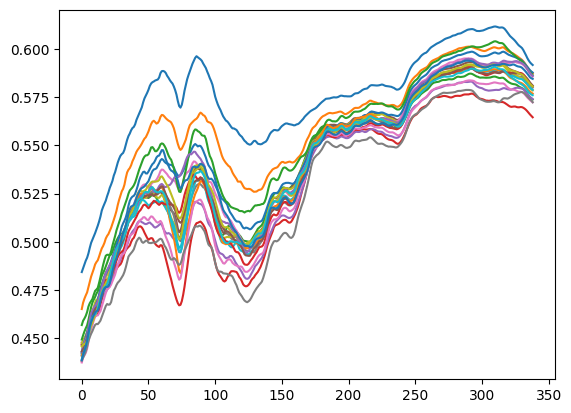

In [26]:
#plt.plot(spectrum)
#plt.plot(spectrum_smooth_mine)
#plt.plot(spectrum_smooth_theirs)
plt.plot(spectrum_smooth_mine_2.T);


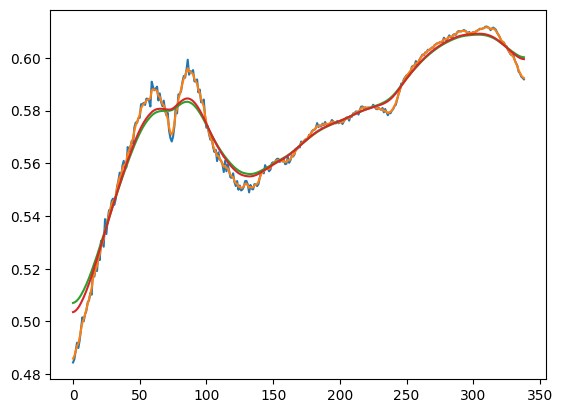

In [45]:
from chemotools.smoothing import WhittakerSmooth as WhittakerSmooth2

ws2 = WhittakerSmooth2(lam=100, differences=1)
spectrum_smooth_mine_3 = ws2.fit_transform(spectrum)
spectrum_smooth_thirs_2 = WhittakerSmooth1(spectrum[0], np.ones_like(spectrum[0]), 1e2)

plt.plot(spectrum[0])
plt.plot(spectrum_smooth_mine_2[0])  # mine
plt.plot(spectrum_smooth_mine_3[0])  # mine 2
plt.plot(spectrum_smooth_thirs_2)  # theirs

In [40]:
spectrum[0]

array([0.484434, 0.485629, 0.488754, 0.491942, 0.489923, 0.492869,
       0.497285, 0.501567, 0.500027, 0.50265 , 0.504031, 0.507229,
       0.507979, 0.510819, 0.510134, 0.52021 , 0.517008, 0.520256,
       0.519134, 0.525934, 0.52327 , 0.530606, 0.529451, 0.528332,
       0.538822, 0.533181, 0.53875 , 0.542191, 0.542244, 0.545774,
       0.546591, 0.544224, 0.546459, 0.551036, 0.553334, 0.556454,
       0.553465, 0.558983, 0.560916, 0.55795 , 0.558521, 0.566159,
       0.564407, 0.566028, 0.568479, 0.567493, 0.573624, 0.575462,
       0.5753  , 0.577093, 0.577257, 0.582415, 0.582413, 0.582927,
       0.58213 , 0.584501, 0.584462, 0.583777, 0.581544, 0.590941,
       0.588938, 0.587698, 0.588341, 0.589064, 0.583842, 0.58653 ,
       0.583313, 0.581686, 0.583783, 0.579995, 0.578197, 0.579116,
       0.572342, 0.569611, 0.568266, 0.570061, 0.574083, 0.581476,
       0.578952, 0.586104, 0.586328, 0.587365, 0.590726, 0.593094,
       0.592451, 0.595229, 0.599291, 0.59359 , 0.594947, 0.594